In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.aruco as aruco
import glob

# Calibrate the camera.

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def calibrate(dirpath, prefix, image_format, square_size, width=9, height=6):
    """ Apply camera calibration operation for images in the given directory path. """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]

    images = glob.glob(dirpath+'/' + prefix + '*.' + image_format)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]
def save_coefficients(mtx, dist, path):
    """ Save the camera matrix and the distortion coefficients to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()
def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

In [12]:
ret, mtx, dist, rvecs, tvecs = calibrate('calibrate_images', 'img', 'jpg', 0.024, 9, 6)
save_coefficients(mtx, dist, '13pro_coef')
print("Calibration is finished. RMS: ", ret)

Calibration is finished. RMS:  8.876811870832384


In [3]:
[camera_matrix, dist_matrix] = load_coefficients('13pro_coef')

In [6]:
cap = cv2.VideoCapture('test.mp4')  # Get the camera source
width = cap.get(cv2. CAP_PROP_FRAME_WIDTH )   # float `width`
height = cap.get(cv2. CAP_PROP_FRAME_HEIGHT )  # float `height`
size = (width, height)
fps = cap.get(cv2. CAP_PROP_FPS)

In [10]:
fps

30.0

In [57]:
cap = cv2.VideoCapture('testbox.mp4')  # Get the camera source
width = cap.get(cv2. CAP_PROP_FRAME_WIDTH )   # float `width`
height = cap.get(cv2. CAP_PROP_FRAME_HEIGHT )  # float `height`
size = (int(width), int(height))
fps = cap.get(cv2. CAP_PROP_FPS)

def track(matrix_coefficients, distortion_coefficients):

    list_frames_detection = []

    while True:
        ret, frame = cap.read()
        if ret == False:
            break
        # operations on the frame come here
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Change grayscale
        aruco_dict = aruco.Dictionary_get(aruco.DICT_5X5_250)  # Use 5x5 dictionary to find markers
        parameters = aruco.DetectorParameters_create()  # Marker detection parameters
        # lists of ids and the corners beloning to each id
        corners, ids, rejected_img_points = aruco.detectMarkers(gray, aruco_dict,
                                                                parameters=parameters)
                                                                # cameraMatrix=matrix_coefficients,
                                                                # distCoeff=distortion_coefficients)
        if np.all(ids is not None):  # If there are markers found by detector
            for i in range(0, len(ids)):  # Iterate in markers
                # Estimate pose of each marker and return the values rvec and tvec---different from camera coefficients
                rvec, tvec, markerPoints = aruco.estimatePoseSingleMarkers(corners[i], 0.02, matrix_coefficients,
                                                                           distortion_coefficients)
                (rvec - tvec).any()  # get rid of that nasty numpy value array error
        x_coors = np.array([])
        y_coors = np.array([])
        for corner in corners:
            x_coors = np.append(x_coors, corner.T[0])
            y_coors = np.append(y_coors, corner.T[1])
        x_min = np.min(x_coors)
        y_min = np.min(y_coors)
        x_max = np.max(x_coors)
        y_max = np.max(y_coors)
        center_x = int((x_max + x_min) / 2)
        center_y = int((y_max + y_min) / 2)
        cv2.rectangle(frame, (int(x_max),int(y_max)), (int(x_min), int(y_min)), (0, 0, 255), 2)
        cv2.circle(frame, (center_x, center_y), 5, (0, 0, 255), -1)
        aruco.drawDetectedMarkers(frame, corners)

        # Draw A square around the markers
        list_frames_detection.append(frame)



    out = cv2.VideoWriter('detection.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for i in range(len(list_frames_detection)):
        out.write(list_frames_detection[i])
    out.release()

track(camera_matrix,dist_matrix)

In [40]:
x_coors = np.array([])

In [45]:
a = np.append(x_coors,np.array([1,2]))
b = np.append(a, np.array([2,4,56]))

In [46]:
b

array([ 1.,  2.,  2.,  4., 56.])

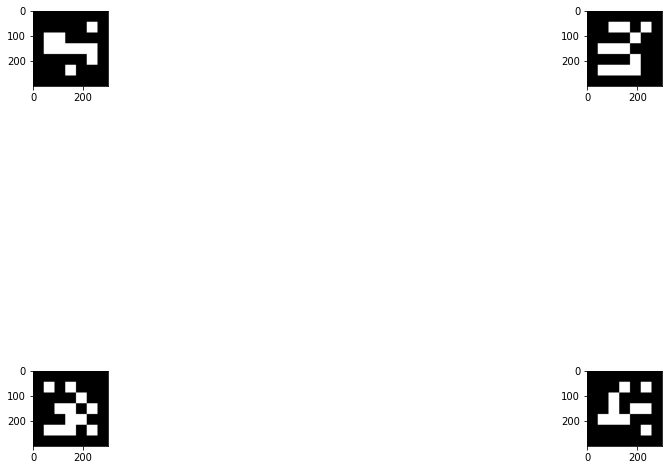

In [35]:
%matplotlib inline
tag1 = np.zeros((300, 300, 1), dtype="uint8")
tag2 = np.zeros((300, 300, 1), dtype="uint8")
tag3 = np.zeros((300, 300, 1), dtype="uint8")
tag4 = np.zeros((300, 300, 1), dtype="uint8")
dictionary = aruco.Dictionary_get(aruco.DICT_5X5_250)
aruco.drawMarker(dictionary, 248, 300, tag1, 1)
aruco.drawMarker(dictionary, 200, 300, tag2, 1)
aruco.drawMarker(dictionary, 150, 300, tag3, 1)
aruco.drawMarker(dictionary, 100, 300, tag4, 1)
fig = plt.figure(num=1, figsize=(12, 8))
# draw the corresponding histogram
plt.subplot(5, 5, 1)
plt.imshow(tag1, cmap = plt.cm.gray)
plt.subplot(5, 5, 5)
plt.imshow(tag2, cmap = plt.cm.gray)
plt.subplot(5, 5, 21)
plt.imshow(tag3, cmap = plt.cm.gray)
plt.subplot(5, 5, 25)
plt.imshow(tag4, cmap = plt.cm.gray)

In [3]:
np.unique(tag)


array([  0, 255], dtype=uint8)

In [4]:
cv2.aruco.DICT_5X5_100

5